In [85]:
import pysolr
import time
from datetime import datetime
import pandas as pd

# Correlation Analysis

In [22]:
import sys
import logging

so = open('cord-19-stats.log', 'w', 10)
sys.stdout.echo = so
sys.stderr.echo = so

get_ipython().log.handlers[0].stream = so
get_ipython().log.setLevel(logging.INFO)

## Create dataframe from paragraphs

In [ ]:
server = 'http://librairy.linkeddata.es/solr'
url = server+'/cord19-paragraphs'
solr = pysolr.Solr(url, always_commit=True, timeout=120)

t = time.time()
finished = False
total = 0
cursor_mark = '*'
data = []
while (not finished):
    try:
        print("Cursor Mark:",cursor_mark)
        results = solr.search('atc_codes_ss:[* TO *]',fl='id,atc_codes_ss',cursorMark=cursor_mark,rows=500,sort='id ASC')
        num_found = len(results.docs)
        hits = results.hits
        next_cursor = results.nextCursorMark
        if (cursor_mark == next_cursor):
            print("End Cursor")
            finished = True
            break
        print("[",datetime.now(),"]","Num_Found:", num_found,"Total:",total,"Hits:",hits)
        cursor_mark = next_cursor
        #total += num_found
        for result in results.docs:
            row = dict.fromkeys(['A','B','C','D','G','H','J','L','M','N','P','R','S','V'],0)
            total += 1
            for atc_code in result['atc_codes_ss']:
                row[atc_code[0]] += 1
            data.append(row)
    except Exception as e:
        print("Error reading from solr:",e)        
print('Elapsed time: {} mins'.format(round((time.time() - t) / 60, 2)))
print("Total Annotations:",total)
df = pd.DataFrame(data)
df.to_csv('cord19-stats.csv',index=True)

## Create correlation matrix

In [86]:
df = pd.read_csv('cord19-stats.csv', index_col=0)
df.rename(columns = {'A':'Alimentary tract \nand metabolism', 
                     'B':'Blood and blood\nforming organs',
                     'C':'Cardiovascular system',
                     'D':'Dermatologicals',
                     'G':'Genito-urinary system\n and sex hormones',
                     'H':'Systemic hormonal preparations,\n excluding sex hormones and insulins',
                     'J':'Antiinfectives for\n systemic use',
                     'L':'Antineoplastic and\n immunomodulating agents',
                     'M':'Musculo-skeletal system',
                     'N':'Nervous system',
                     'P':'Antiparasitic products,\n insecticides and repellents',
                     'R':'Respiratory system',
                     'S':'Sensory organs',
                     'V':'Various'
                    }, inplace = True)

In [87]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,Alimentary tract and metabolism,Blood and blood forming organs,Cardiovascular system,Dermatologicals,Genito-urinary system and sex hormones,"Systemic hormonal preparations, excluding sex hormones and insulins",Antiinfectives for systemic use,Antineoplastic and immunomodulating agents,Musculo-skeletal system,Nervous system,"Antiparasitic products, insecticides and repellents",Respiratory system,Sensory organs,Various
Alimentary tract and metabolism,1.000000,-0.005489,-0.011613,-0.059478,-0.035374,-0.003006,-0.062314,-0.084717,-0.017981,-0.062208,-0.083146,-0.033104,-0.006013,-0.119557
Blood and blood forming organs,-0.005489,1.000000,0.002754,-0.036061,-0.017901,-0.016469,-0.039136,-0.043243,-0.011493,-0.031211,-0.036670,-0.016496,-0.018695,-0.075660
Cardiovascular system,-0.011613,0.002754,1.000000,-0.043494,0.009800,0.011531,-0.029535,-0.034428,0.001418,0.020473,-0.036420,0.007429,-0.011970,-0.078021
Dermatologicals,-0.059478,-0.036061,-0.043494,1.000000,-0.027974,0.018126,-0.020298,-0.030092,-0.015467,-0.046059,-0.032457,0.013470,-0.009589,-0.108826
Genito-urinary system and sex hormones,-0.035374,-0.017901,0.009800,-0.027974,1.000000,0.016804,-0.026345,-0.018662,0.005181,-0.017713,-0.035373,0.002875,-0.011024,-0.057559
"Systemic hormonal preparations, excluding sex hormones and insulins",-0.003006,-0.016469,0.011531,0.018126,0.016804,1.000000,-0.016790,-0.014634,0.004148,-0.019837,-0.023944,0.006381,-0.002057,-0.042630
Antiinfectives for systemic use,-0.062314,-0.039136,-0.029535,-0.020298,-0.026345,-0.016790,1.000000,-0.034022,-0.010882,-0.032630,0.042362,-0.022722,0.213306,-0.118089
Antineoplastic and immunomodulating agents,-0.084717,-0.043243,-0.034428,-0.030092,-0.018662,-0.014634,-0.034022,1.000000,0.004134,-0.058492,-0.024670,-0.014692,-0.039929,-0.132174
Musculo-skeletal system,-0.017981,-0.011493,0.001418,-0.015467,0.005181,0.004148,-0.010882,0.004134,1.000000,0.010519,-0.010138,0.011383,0.002455,-0.053799
Nervous system,-0.062208,-0.031211,0.020473,-0.046059,-0.017713,-0.019837,-0.032630,-0.058492,0.010519,1.000000,-0.045647,0.021356,-0.014931,-0.089775


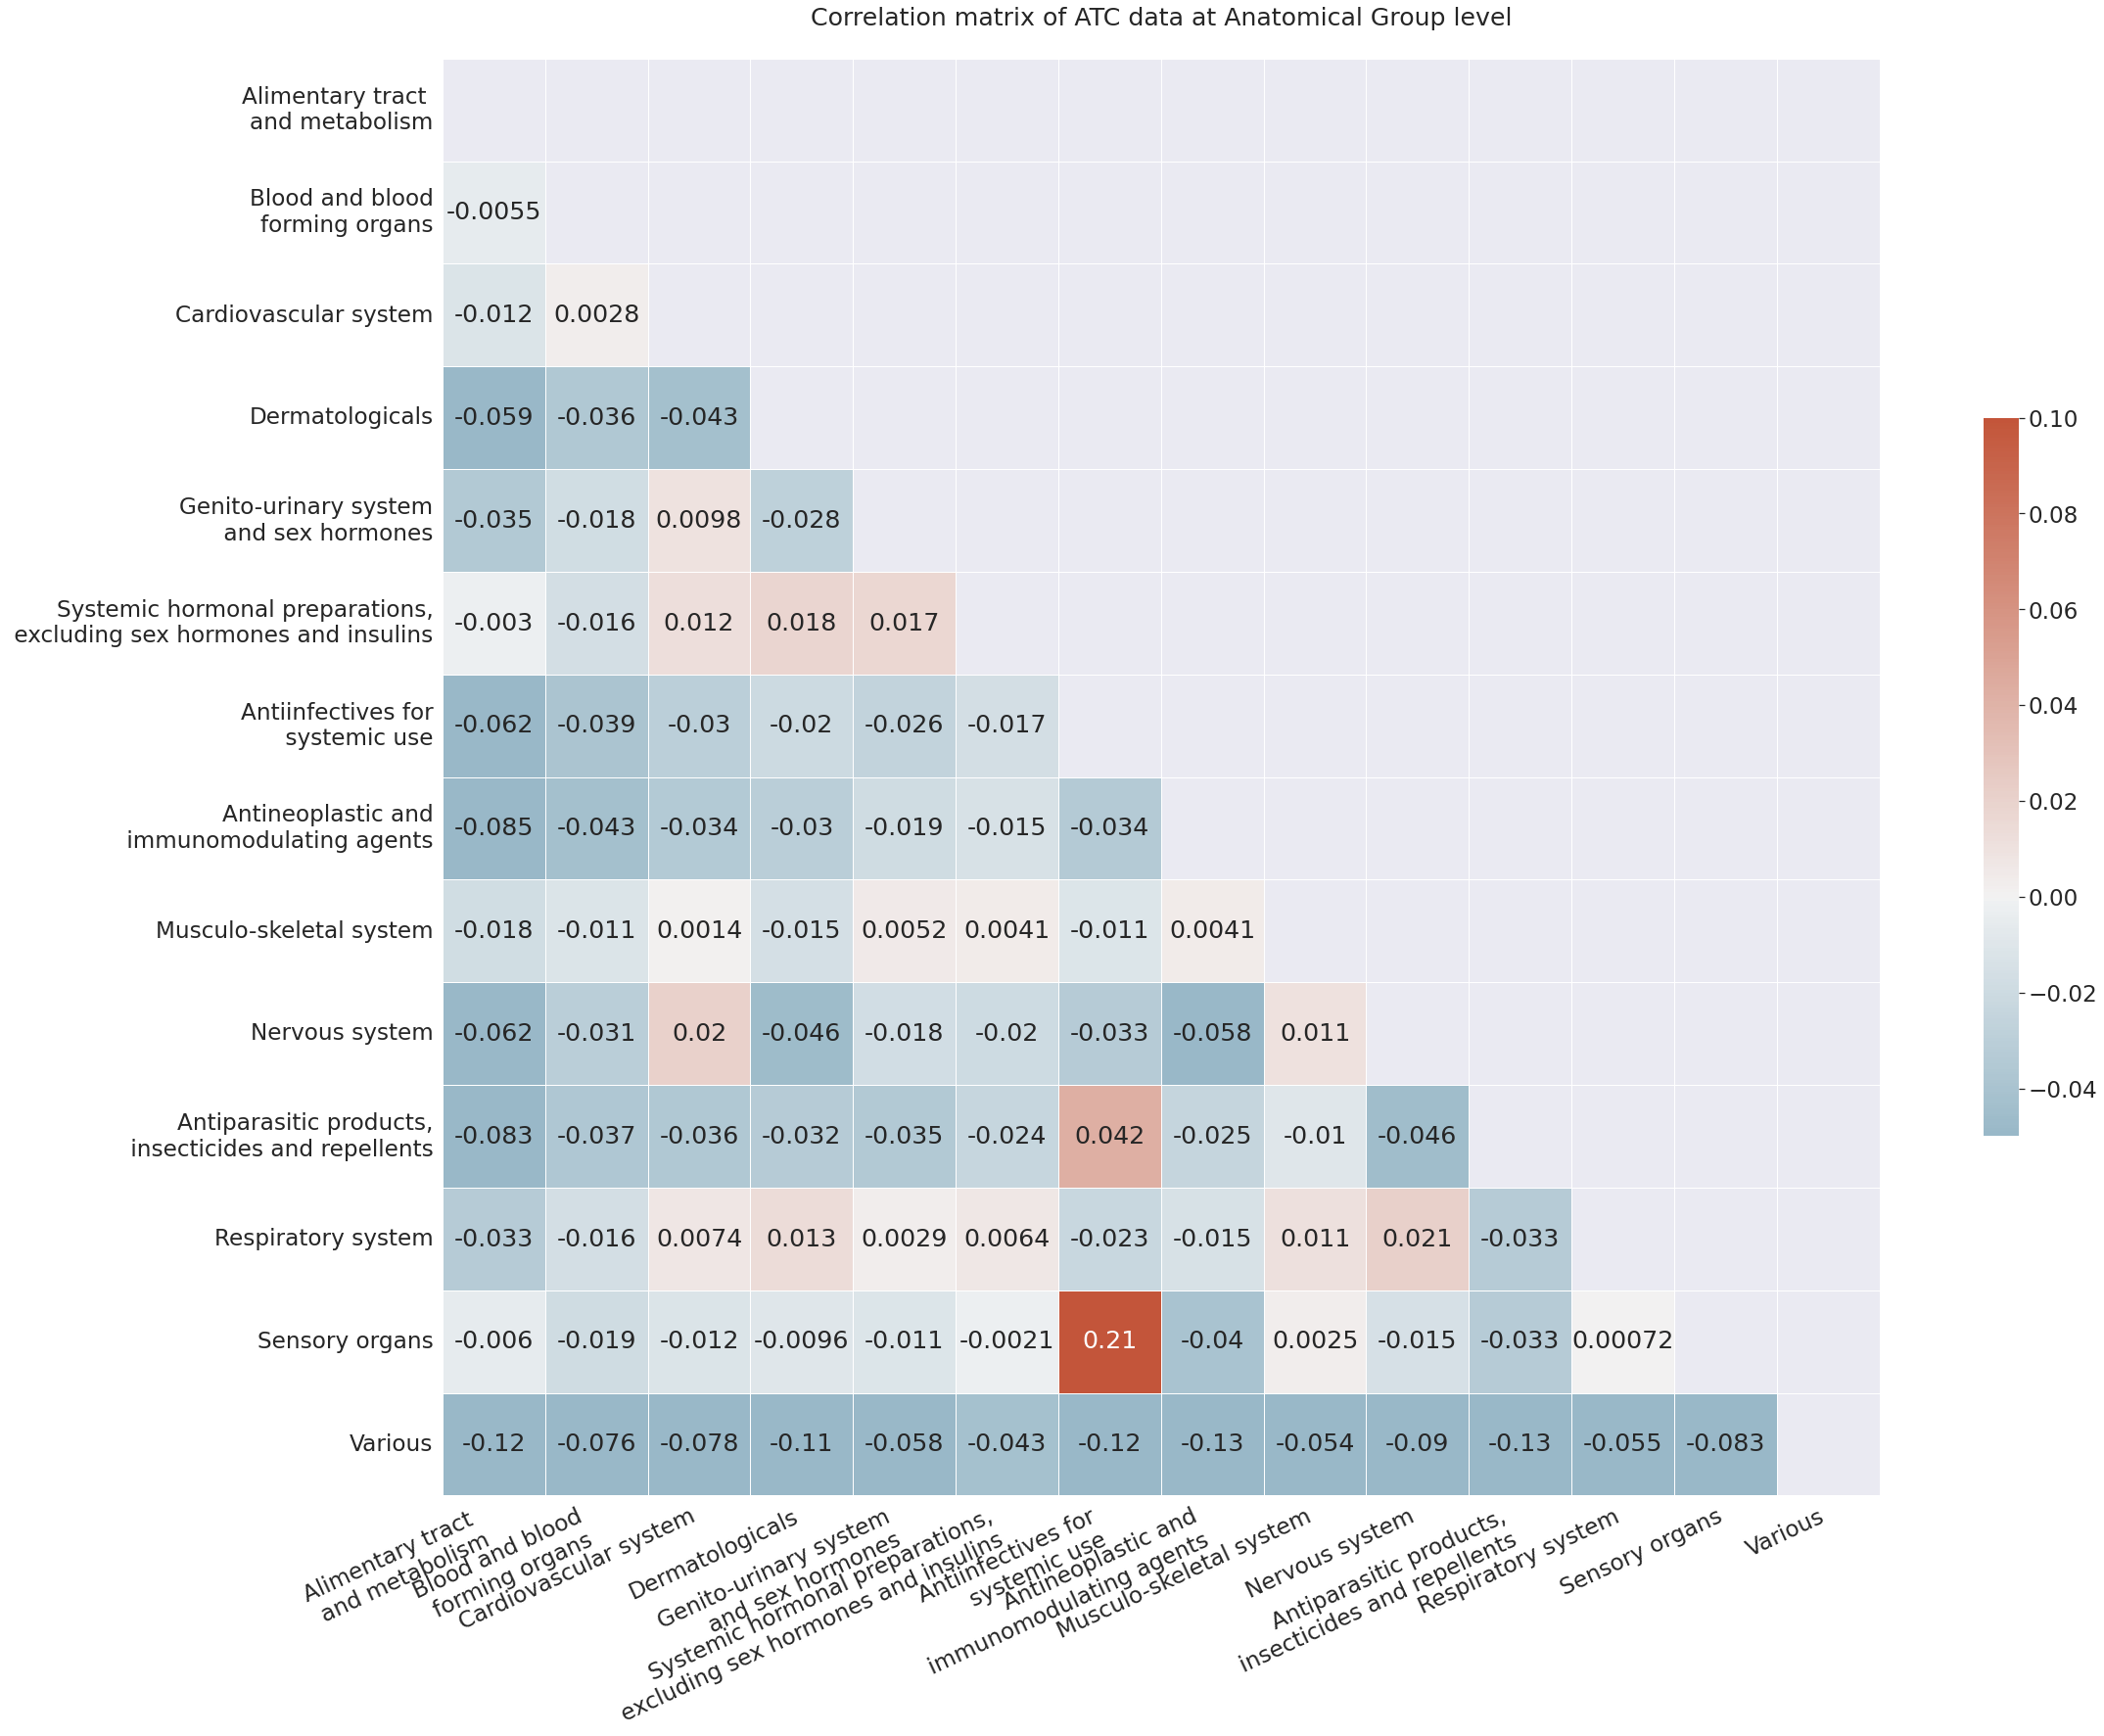

In [88]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")
sns.set(font_scale=2.1)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(38, 27))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
hm = sns.heatmap(corr, mask=mask, annot = True, cmap=cmap, vmax=.1, vmin=-0.05, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

for i in ax.get_yticklabels():
    i.set_ha('right')
    i.set_rotation(0)

for i in ax.get_xticklabels():
    i.set_ha('right')
    i.set_rotation(25)
    
    
hm.set(title = "Correlation matrix of ATC data at Anatomical Group level\n") 

plt.savefig("atc-correlation2.png")

plt.show()    

# Solr Dump


In [83]:
import sys
import logging

so = open('cord-19-dump.log', 'w', 10)
sys.stdout.echo = so
sys.stderr.echo = so

get_ipython().log.handlers[0].stream = so
get_ipython().log.setLevel(logging.INFO)

In [ ]:
import json
server = 'http://librairy.linkeddata.es/solr'
url = server+'/cord19-paragraphs'
solr = pysolr.Solr(url, always_commit=True, timeout=120)

t = time.time()
finished = False
total = 0
cursor_mark = '*'
f = open("cord19-paragraphs.jsonl", "w")
while (not finished):
    try:
        print("Cursor Mark:",cursor_mark)
        results = solr.search('diseases_ss:[* TO *] OR chemicals_ss:[* TO *] OR genetics_ss:[* TO *]',cursorMark=cursor_mark,rows=100,sort='id ASC')
        num_found = len(results.docs)
        hits = results.hits
        next_cursor = results.nextCursorMark
        if (cursor_mark == next_cursor):
            print("End Cursor")
            finished = True
        print("[",datetime.now(),"]","Num_Found:", num_found,"Total:",total,"Hits:",hits)
        cursor_mark = next_cursor
        for result in results.docs:
            total += 1
            json_string = json.dumps(result)
            f.write(json_string+"\n")
    except Exception as e:
        print("Error reading from solr:",e)        
print('Elapsed time: {} mins'.format(round((time.time() - t) / 60, 2)))
print("Total Annotations:",total)
f.close()